In [1]:
import time
import matplotlib.pyplot as plt

try:
    from gpu_mc import IsingModel
except ModuleNotFoundError:
    !git clone https://github.com/ToelUl/Thermal-Phase-Transition-MC-GPU-Simulation.git
    !cp -r Thermal-Phase-Transition-MC-GPU-Simulation/gpu_mc ./
    from gpu_mc import IsingModel

import torch

if not torch.cuda.is_available():
    print("⚠️ GPU runtime is not enabled. Please go to 'Runtime' > 'Change runtime type' and set 'Hardware accelerator' to 'GPU'.")
else:
    print("✅ GPU runtime is enabled and ready!")

✅ GPU runtime is enabled and ready!


In [2]:
L = 16 # Lattice size
T_start = 1.0 # Start temperature
T_end = 3.5 # End temperature
precision = 0.05 # Temperature precision
device = "cuda:0"
T = torch.linspace(T_start, T_end, int((T_end-T_start)//precision)+1, device=device)
ensemble_number = 3000 # Number of samples
n_chains = 30 # Number of parallel chains. Suggested: 10~50
factor_therm = 5 # 10~50
factor_decorrelate = 1 # 1~10
tau = L**2 # Autocorrelation time
n_therm =  int(factor_therm * tau) # Number of thermalization sweeps
decorrelate = int(factor_decorrelate * L) # Number of decorrelation sweeps
n_sweeps = int(ensemble_number / n_chains) * decorrelate # Number of sweeps

print(f"Lattice size: {L}")
print(f"Temperature range: {T_start} to {T_end}")
print(f"Number of temperatures: {len(T)}")
print(f"Number of samples per temperature: {ensemble_number}")
print(f"Number of sweeps: {n_sweeps}")
print(f"Number of thermalization sweeps: {n_therm}")
print(f"Number of chains: {n_chains}")
print(f"Number of decorrelate: {decorrelate}")

sampler_ising = IsingModel(
    L=L,
    T=T,
    n_chains=n_chains,
    device=torch.device("cuda"),
    )

start = time.time()
samples_ising = sampler_ising(n_sweeps=n_sweeps, n_therm=n_therm, decorrelate=decorrelate)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Lattice size: 16
Temperature range: 1.0 to 3.5
Number of temperatures: 50
Number of samples per temperature: 3000
Number of sweeps: 1600
Number of thermalization sweeps: 1280
Number of chains: 30
Number of decorrelate: 16
Elapsed time: 2.84 s


Samples shape: torch.Size([50, 3000, 16, 16])


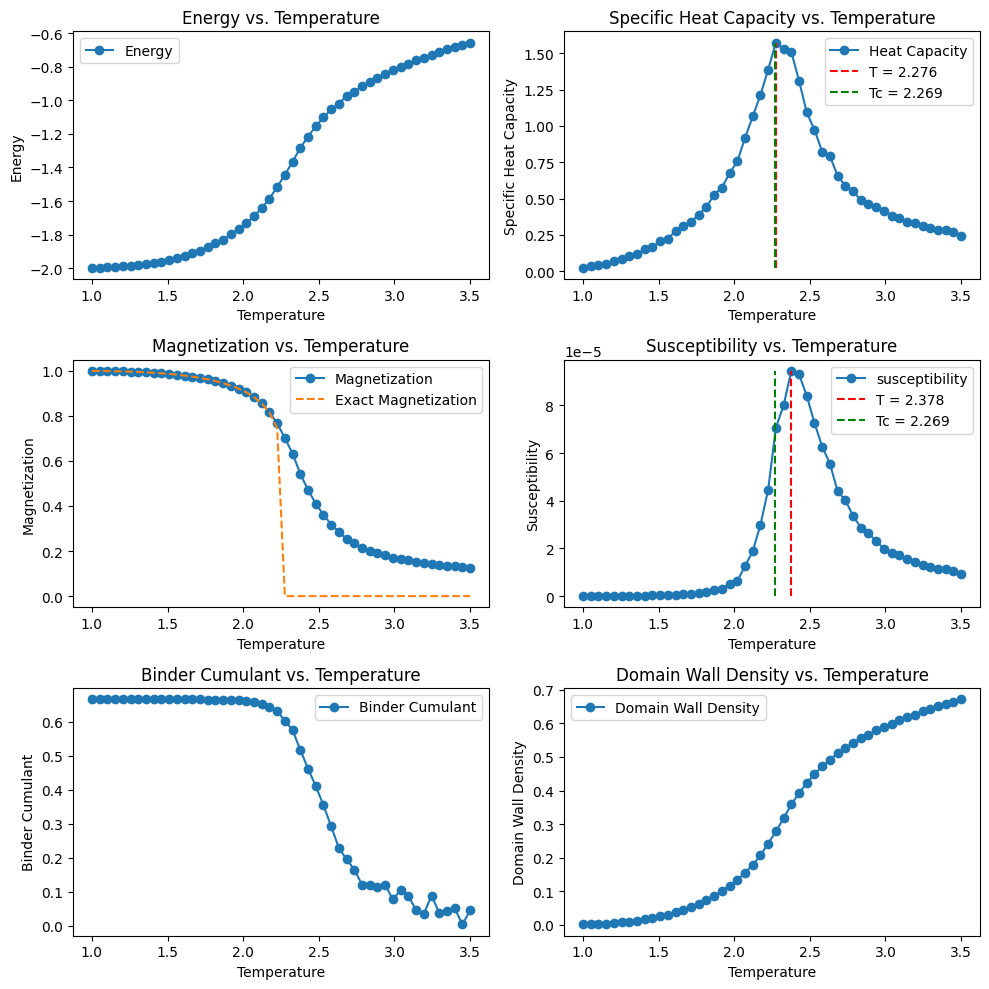

In [3]:
print(f"Samples shape: {samples_ising.shape}")

sampler_ising.spins = samples_ising

energy_ising = sampler_ising.compute_average_energy().cpu().numpy()
capacity_ising = sampler_ising.compute_specific_heat_capacity().cpu().numpy()
magnetization_ising = sampler_ising.compute_magnetization().cpu().numpy()
exact_magnetization_ising = sampler_ising.compute_exact_magnetization().cpu().numpy()
susceptibility_ising = sampler_ising.compute_susceptibility().cpu().numpy()
binder_cumulant_ising = sampler_ising.compute_binder_cumulant().cpu().numpy()
domain_wall_density_ising = sampler_ising.compute_domain_wall_density().cpu().numpy()
temp = sampler_ising.T.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(321)
plt.plot(temp, energy_ising, label='Energy', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.title('Energy vs. Temperature')
plt.legend()
plt.subplot(322)
plt.plot(temp, capacity_ising, label='Heat Capacity', marker='o')
plt.vlines(temp[capacity_ising.argmax()], capacity_ising.min(), capacity_ising.max(),
              color='red', linestyle='--', label='T = %.3f' % temp[capacity_ising.argmax()])
plt.vlines(2.269, capacity_ising.min(), capacity_ising.max(), color='green', linestyle='--', label='Tc = 2.269')
plt.xlabel('Temperature')
plt.ylabel('Specific Heat Capacity')
plt.title('Specific Heat Capacity vs. Temperature')
plt.legend()
plt.subplot(323)
plt.plot(temp, magnetization_ising, label='Magnetization', marker='o')
plt.plot(temp, exact_magnetization_ising, label='Exact Magnetization', linestyle='--')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.title('Magnetization vs. Temperature')
plt.legend()
plt.subplot(324)
plt.plot(temp, susceptibility_ising, label='susceptibility', marker='o')
plt.vlines(temp[susceptibility_ising.argmax()], susceptibility_ising.min(), susceptibility_ising.max(),
                color='red', linestyle='--', label='T = %.3f' % temp[susceptibility_ising.argmax()])
plt.vlines(2.269, susceptibility_ising.min(), susceptibility_ising.max(), color='green', linestyle='--', label='Tc = 2.269')
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.title('Susceptibility vs. Temperature')
plt.legend()
plt.subplot(325)
plt.plot(temp, binder_cumulant_ising, label='Binder Cumulant', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Binder Cumulant')
plt.title('Binder Cumulant vs. Temperature')
plt.legend()
plt.subplot(326)
plt.plot(temp, domain_wall_density_ising, label='Domain Wall Density', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Domain Wall Density')
plt.title('Domain Wall Density vs. Temperature')
plt.legend()
plt.tight_layout()
plt.show()
torch.cuda.empty_cache()